DBSCAN (Clustering basado en densidad)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


In [2]:
# Cargar datos
df_fraude = pd.read_csv('fraud_test.csv', sep=",")
df_fraude.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [3]:
# Para facilitar nuestro dataset, se renombran las columnnas de ingles a español.
# Diccionario de mapeo de nombres en inglés a español
columnas_renombradas = {
    'trans_date_trans_time': 'fecha_transaccion',
    'cc_num': 'num_tarjeta',
    'merchant': 'comerciante',
    'category': 'categoria',
    'amt': 'monto',
    'first': 'nombre',
    'last': 'apellido',
    'gender': 'genero',
    'street': 'calle',
    'city': 'ciudad',
    'state': 'estado',
    'zip': 'codigo_postal',
    'lat': 'latitud',
    'long': 'longitud',
    'city_pop': 'poblacion_ciudad',
    'job': 'trabajo',
    'dob': 'fecha_nacimiento',
    'trans_num': 'num_transaccion',
    'unix_time': 'tiempo_unix',
    'merch_lat': 'latitud_comerciante',
    'merch_long': 'longitud_comerciante',
    'is_fraud': 'es_fraude'
}

# Renombramos las columnas
df_fraude.rename(columns=columnas_renombradas, inplace=True)

# Mostramos los nuevos nombres de las columnas
print("Columnas renombradas:", df_fraude.columns)

Columnas renombradas: Index(['Unnamed: 0', 'fecha_transaccion', 'num_tarjeta', 'comerciante',
       'categoria', 'monto', 'nombre', 'apellido', 'genero', 'calle', 'ciudad',
       'estado', 'codigo_postal', 'latitud', 'longitud', 'poblacion_ciudad',
       'trabajo', 'fecha_nacimiento', 'num_transaccion', 'tiempo_unix',
       'latitud_comerciante', 'longitud_comerciante', 'es_fraude'],
      dtype='object')


In [4]:
# Convertir la columna 'fecha_nacimiento' a tipo datetime y calcular la edad
df_fraude['fecha_nacimiento'] = pd.to_datetime(df_fraude['fecha_nacimiento'])
df_fraude['edad'] = 2020 - df_fraude['fecha_nacimiento'].dt.year

# Aplicar grupo de edad
def aplicar_grupo_edad(edad):
    if edad <= 18:
        return 'Adolescente'
    elif edad <= 25:
        return 'Joven Adulto'
    elif edad <= 64:
        return 'Adulto'
    else:
        return 'Anciano'

df_fraude['grupo_edad'] = df_fraude['edad'].apply(aplicar_grupo_edad)
df_fraude['no_fraude'] = df_fraude['es_fraude'].apply(lambda x: 1 if x == 0 else 0)

C:\Users\bever\AppData\Local\Temp\ipykernel_12488\3238147962.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_fraude['fecha_nacimiento'] = pd.to_datetime(df_fraude['fecha_nacimiento'])


In [33]:
# Información del DataFrame
df_fraude.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            555719 non-null  int64         
 1   fecha_transaccion     555719 non-null  object        
 2   num_tarjeta           555719 non-null  float64       
 3   comerciante           555719 non-null  object        
 4   categoria             555719 non-null  object        
 5   monto                 555719 non-null  float64       
 6   nombre                555719 non-null  object        
 7   apellido              555719 non-null  object        
 8   genero                555719 non-null  object        
 9   calle                 555719 non-null  object        
 10  ciudad                555719 non-null  object        
 11  estado                555719 non-null  object        
 12  codigo_postal         555719 non-null  int64         
 13 

In [34]:
# Seleccionar características relevantes
caracteristicas = ['monto', 'grupo_edad', 'codigo_postal', 'poblacion_ciudad']

In [35]:
# Crear preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['monto', 'codigo_postal', 'poblacion_ciudad']),
        ('cat', OneHotEncoder(), ['grupo_edad'])
    ])

# Aplicar preprocesamiento
X = preprocessor.fit_transform(df_fraude[caracteristicas])

In [37]:
# Tomar una muestra aleatoria aún más pequeña si es necesario
df_sample = df_fraude.sample(n=5000, random_state=42)

# Aplicar PCA para reducción de dimensionalidad
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[:len(df_sample)])

# Aplicar DBSCAN en el subconjunto reducido
dbscan = DBSCAN(eps=0.5, min_samples=10)
df_sample['cluster'] = dbscan.fit_predict(X_pca)

C:\Users\bever\AppData\Local\Temp\ipykernel_12488\3784390141.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='Cluster ID')


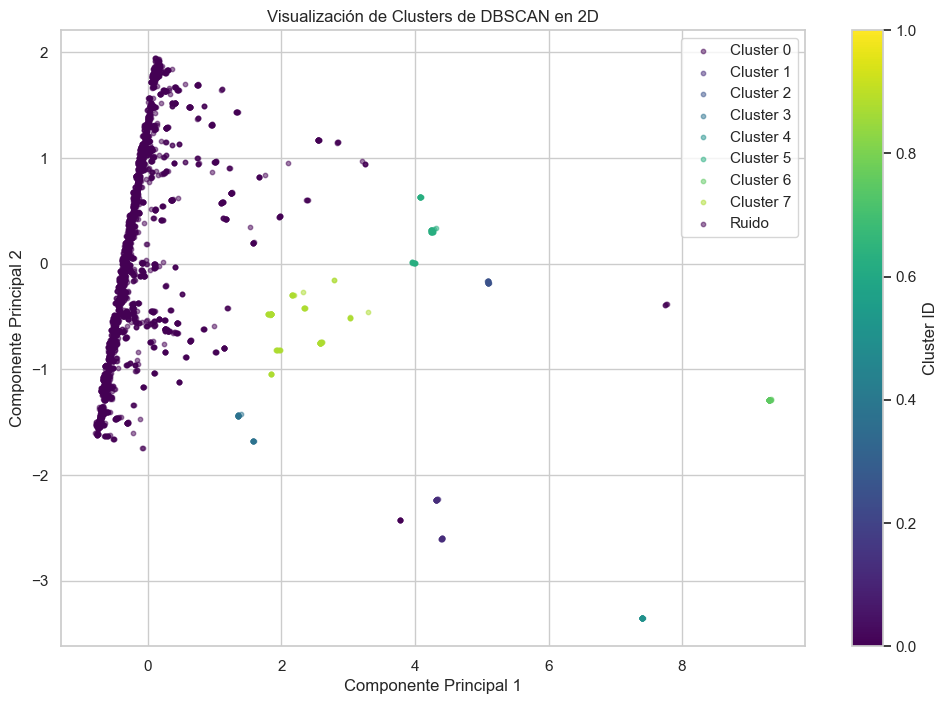

In [38]:
# Visualización de Clusters en 2D
plt.figure(figsize=(12, 8))
unique_clusters = df_sample['cluster'].unique()
colors = plt.get_cmap('viridis', len(unique_clusters))
for cluster in unique_clusters:
    mask = df_sample['cluster'] == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                color=colors(cluster / len(unique_clusters)),
                label=f'Cluster {cluster}' if cluster != -1 else 'Ruido',
                alpha=0.5, s=10)
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='Cluster ID')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Clusters de DBSCAN en 2D')
plt.legend()
plt.grid(True)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

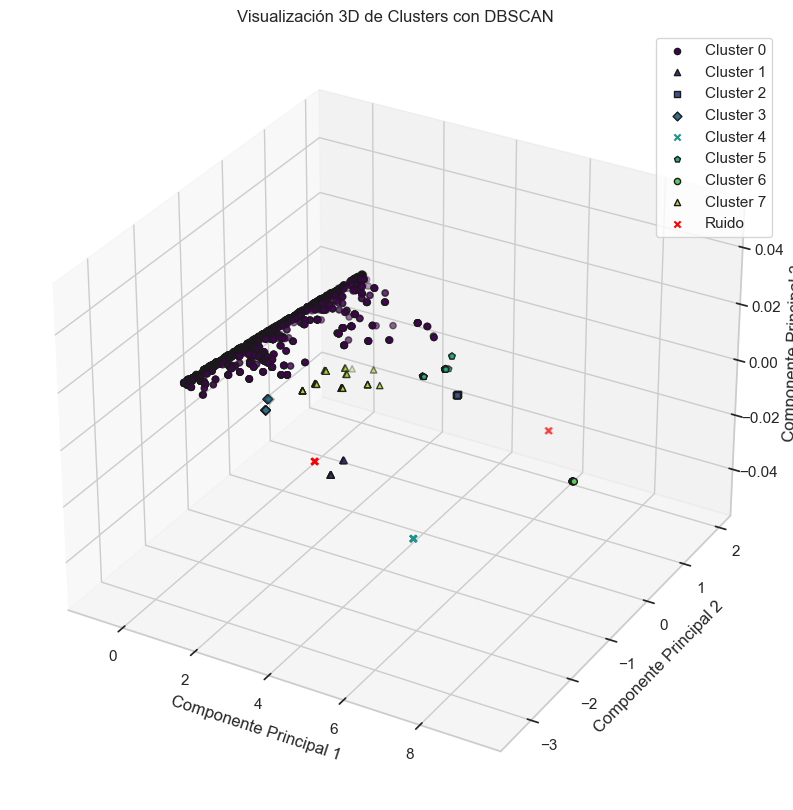

In [39]:
# Visualización de Clusters en 3D
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
unique_clusters = df_sample['cluster'].unique()
colors = plt.get_cmap('viridis', len(unique_clusters))
marker_styles = ['o', '^', 's', 'D', 'x', 'p']
for i, cluster in enumerate(unique_clusters):
    mask = df_sample['cluster'] == cluster
    if cluster == -1:
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c='red', label='Ruido', edgecolor='k', marker='x')
    else:
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors(i), label=f'Cluster {cluster}', edgecolor='k', marker=marker_styles[i % len(marker_styles)])
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
plt.title('Visualización 3D de Clusters con DBSCAN')
plt.legend()
plt.show()

Puntuación Promedio de Silueta: 0.4766033390294665


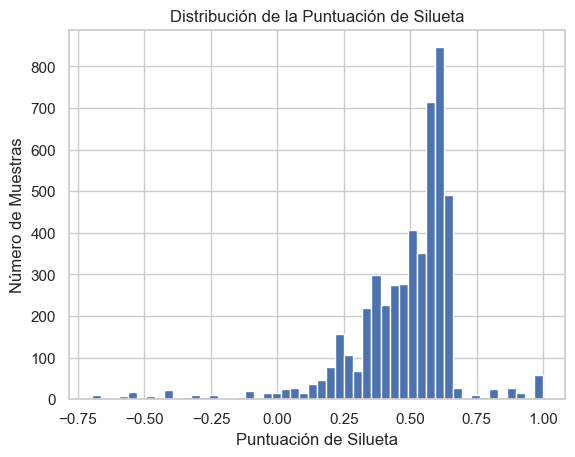

In [40]:
# Evaluar el modelo
silhouette_avg = silhouette_score(X_pca, df_sample['cluster'])
print(f'Puntuación Promedio de Silueta: {silhouette_avg}')

silhouette_values = silhouette_samples(X_pca, df_sample['cluster'])
plt.hist(silhouette_values, bins=50)
plt.title('Distribución de la Puntuación de Silueta')
plt.xlabel('Puntuación de Silueta')
plt.ylabel('Número de Muestras')
plt.show()


In [41]:
# Verificar y mostrar ejemplos de un cluster específico
cluster_id = 0  # Cambia este valor para examinar otros clusters
if cluster_id in df_sample['cluster'].unique():
    examples = df_sample[df_sample['cluster'] == cluster_id].head(10)
    print(f"Ejemplos de puntos en el cluster {cluster_id}:")
    print(examples[['monto', 'codigo_postal', 'poblacion_ciudad', 'grupo_edad']])
else:
    print(f"El cluster {cluster_id} no existe en los datos.")

Ejemplos de puntos en el cluster 0:
        monto  codigo_postal  poblacion_ciudad grupo_edad
119106   1.07           6441              5438     Adulto
179292  94.99          74047              7163     Adulto
540729  31.28          64630               602    Anciano
374360  73.06          74047              7163     Adulto
314574   9.99          51521              2036     Adulto
377296  28.50          78040            248858     Adulto
399943   9.09          13647                69     Adulto
1481     1.64          21524               626     Adulto
465665  55.90          76626              1563     Adulto
430957  50.61          92585             54287     Adulto


In [42]:
# Calcular estadísticas descriptivas por cluster
if 'cluster' in df_sample.columns and not df_sample['cluster'].empty:
    cluster_stats = df_sample.groupby('cluster').agg({
        'monto': ['mean', 'std', 'min', 'max'],
        'codigo_postal': ['mean', 'std', 'min', 'max'],
        'poblacion_ciudad': ['mean', 'std', 'min', 'max']
    }).reset_index()
    print("Estadísticas descriptivas por cluster:")
    print(cluster_stats)
else:
    print("No se encontraron clusters en los datos.")

Estadísticas descriptivas por cluster:
  cluster      monto                            codigo_postal                \
                mean         std   min      max          mean           std   
0      -1  69.786000   58.543278  2.65   157.75  44729.600000  21899.992492   
1       0  69.046720  164.511756  1.00  5936.80  49153.545703  26639.214510   
2       1  54.072000   57.557557  3.19   214.27  40552.840000  24830.396981   
3       2  51.240588   49.790684  2.43   167.59  45381.352941  30554.632188   
4       3  73.611600   83.294084  2.21   346.43  44198.760000  26888.026402   
5       4  45.313529   40.383162  4.08   142.95  61373.705882  27755.548175   
6       5  56.471064   44.094693  1.18   181.25  50165.234043  26885.562806   
7       6  72.771600  164.275635  1.40   809.11  57238.520000  30537.677600   
8       7  62.972133   88.086678  1.87   543.39  44683.106667  23182.531533   

               poblacion_ciudad                               
    min    max             m

In [43]:
# Mostrar número de clusters y puntos de ruido
num_clusters = len(unique_clusters) - 1  # excluyendo ruido
num_ruido = sum(df_sample['cluster'] == -1)
print(f"Número de Clusters: {num_clusters}")
print(f"Número de puntos de ruido: {num_ruido}")

Número de Clusters: 8
Número de puntos de ruido: 10


Ajustamos el modelo DBSCAN

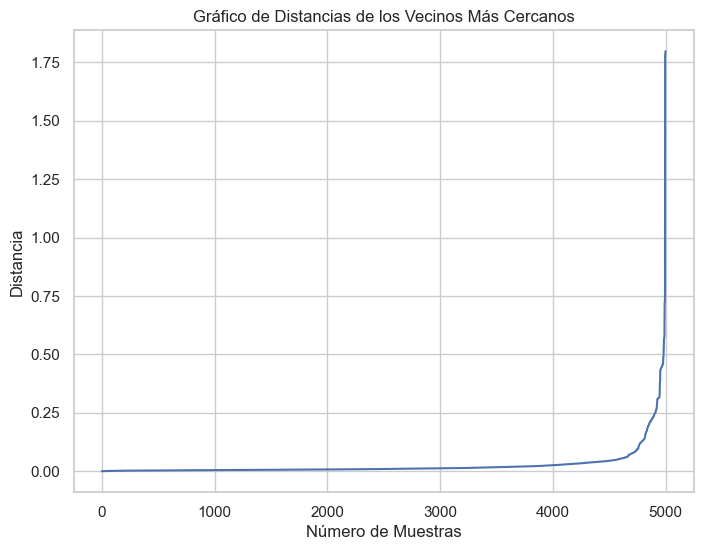

In [45]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Calcular la distancia k más cercana
neighbors = NearestNeighbors(n_neighbors=10).fit(X_pca)
distances, _ = neighbors.kneighbors(X_pca)
distances = np.sort(distances[:, -1], axis=0)
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('Gráfico de Distancias de los Vecinos Más Cercanos')
plt.xlabel('Número de Muestras')
plt.ylabel('Distancia')
plt.show()


In [46]:
# Preprocesamiento y transformación de datos
df_fraude.rename(columns=columnas_renombradas, inplace=True)
df_fraude['fecha_nacimiento'] = pd.to_datetime(df_fraude['fecha_nacimiento'])
df_fraude['edad'] = 2020 - df_fraude['fecha_nacimiento'].dt.year
df_fraude['grupo_edad'] = df_fraude['edad'].apply(aplicar_grupo_edad)
df_fraude['no_fraude'] = df_fraude['es_fraude'].apply(lambda x: 1 if x == 0 else 0)

caracteristicas = ['monto', 'grupo_edad', 'codigo_postal', 'poblacion_ciudad']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['monto', 'codigo_postal', 'poblacion_ciudad']),
        ('cat', OneHotEncoder(), ['grupo_edad'])
    ])
X = preprocessor.fit_transform(df_fraude[caracteristicas])

In [47]:
# Seleccionar una muestra aleatoria
df_sample = df_fraude.sample(n=5000, random_state=42)

# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

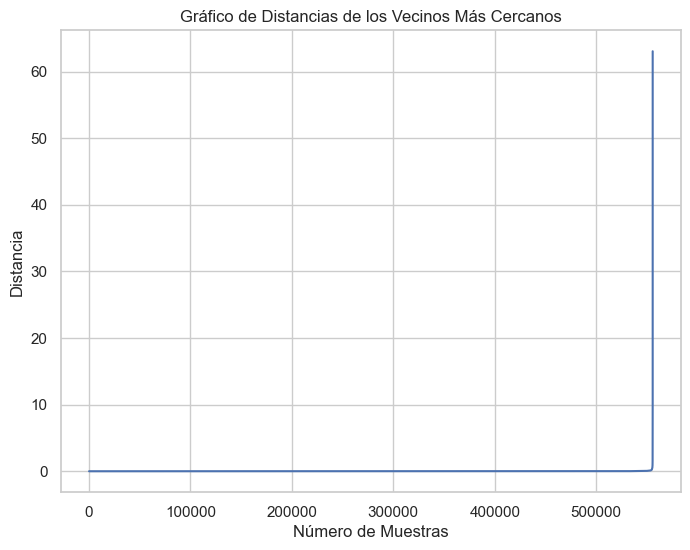

In [48]:
# Encontrar un buen valor de `eps` usando la gráfica de distancias
neighbors = NearestNeighbors(n_neighbors=10).fit(X_pca)
distances, _ = neighbors.kneighbors(X_pca)
distances = np.sort(distances[:, -1], axis=0)
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('Gráfico de Distancias de los Vecinos Más Cercanos')
plt.xlabel('Número de Muestras')
plt.ylabel('Distancia')
plt.show()

In [51]:
df_sample = df_fraude.sample(n=1000, random_state=42)
X = preprocessor.fit_transform(df_sample[caracteristicas])
X_pca = pca.fit_transform(X)


# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)  # Ajusta `eps` y `min_samples` según el gráfico anterior
df_sample['cluster'] = dbscan.fit_predict(X_pca)

C:\Users\bever\AppData\Local\Temp\ipykernel_12488\424259375.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='Cluster ID')


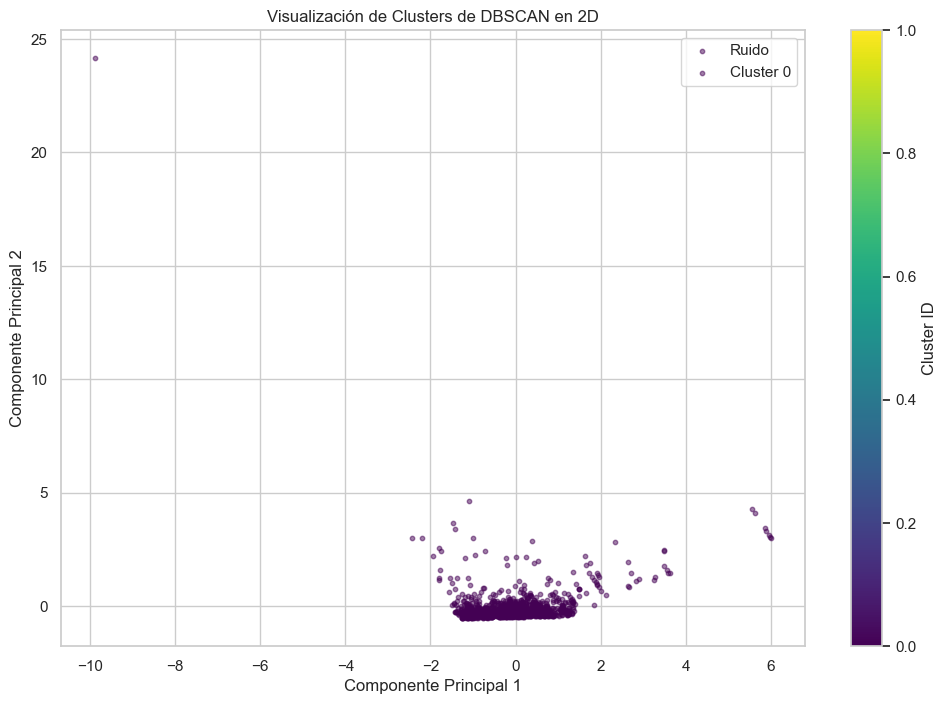

In [53]:
# Visualización 2D y 3D
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(12, 8))
    unique_clusters = np.unique(labels)
    colors = plt.get_cmap('viridis', len(unique_clusters))
    for cluster in unique_clusters:
        mask = labels == cluster
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                    color=colors(cluster / len(unique_clusters)),
                    label=f'Cluster {cluster}' if cluster != -1 else 'Ruido',
                    alpha=0.5, s=10)
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='Cluster ID')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    # Gráficos 2D
plot_clusters(X_pca, df_sample['cluster'], 'Visualización de Clusters de DBSCAN en 2D')

C:\Users\bever\AppData\Local\Temp\ipykernel_12488\3506001907.py:11: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pca_3d[mask, 0], pca_3d[mask, 1], pca_3d[mask, 2],


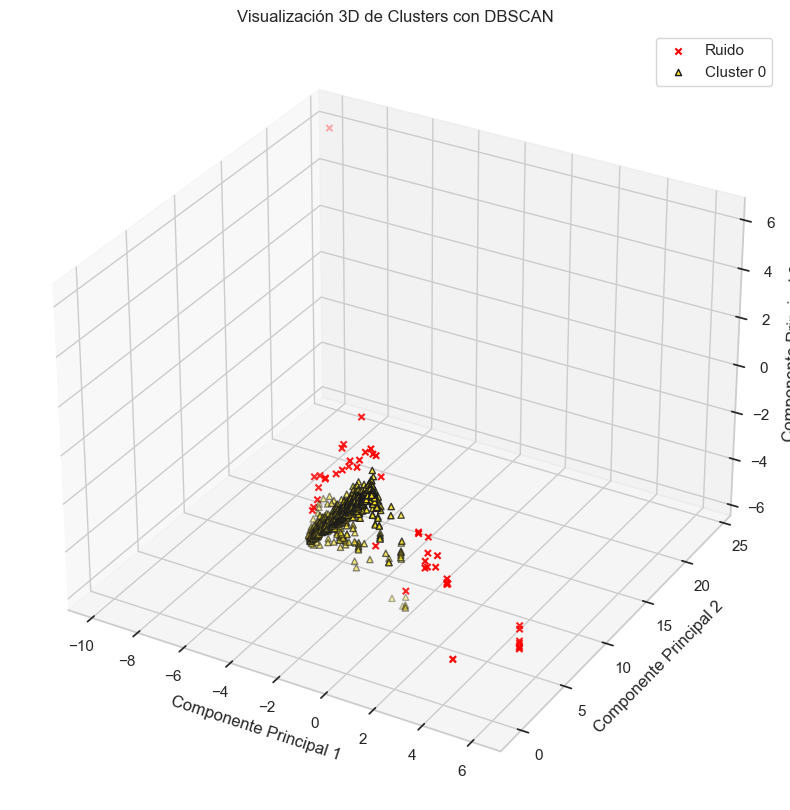

Puntuación Promedio de Silueta: 0.7178822128369298


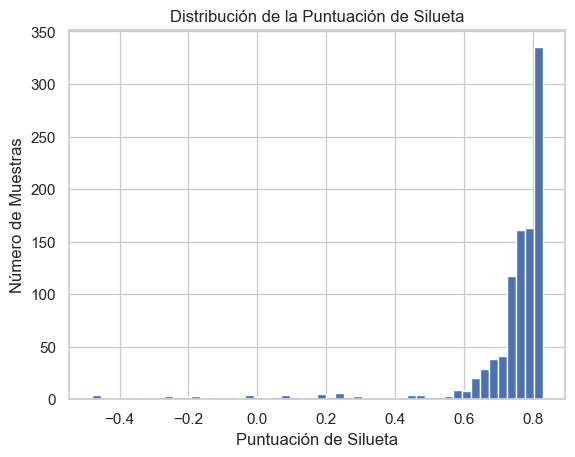

Ejemplos de puntos en el cluster 0:
        monto  codigo_postal  poblacion_ciudad grupo_edad
119106   1.07           6441              5438     Adulto
179292  94.99          74047              7163     Adulto
540729  31.28          64630               602    Anciano
374360  73.06          74047              7163     Adulto
314574   9.99          51521              2036     Adulto
377296  28.50          78040            248858     Adulto
399943   9.09          13647                69     Adulto
1481     1.64          21524               626     Adulto
465665  55.90          76626              1563     Adulto
430957  50.61          92585             54287     Adulto
Estadísticas descriptivas por cluster:
  cluster       monto                            codigo_postal                \
                 mean         std   min      max          mean           std   
0      -1  422.464792  737.050065  2.27  5044.68  59047.291667  30755.657541   
1       0   56.198687   55.841108  1.01   360.1

In [54]:

# Gráficos 3D si es necesario
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
pca_3d = PCA(n_components=3).fit_transform(X)
unique_clusters = np.unique(df_sample['cluster'])
colors = plt.get_cmap('viridis', len(unique_clusters))
marker_styles = ['o', '^', 's', 'D', 'x', 'p']
for i, cluster in enumerate(unique_clusters):
    mask = df_sample['cluster'] == cluster
    if cluster == -1:
        ax.scatter(pca_3d[mask, 0], pca_3d[mask, 1], pca_3d[mask, 2],
                   color='red', label='Ruido', edgecolor='k', marker='x')
    else:
        ax.scatter(pca_3d[mask, 0], pca_3d[mask, 1], pca_3d[mask, 2],
                   color=colors(i), label=f'Cluster {cluster}', edgecolor='k', marker=marker_styles[i % len(marker_styles)])
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
plt.title('Visualización 3D de Clusters con DBSCAN')
plt.legend()
plt.show()

# Evaluación del modelo
silhouette_avg = silhouette_score(X_pca, df_sample['cluster'])
print(f'Puntuación Promedio de Silueta: {silhouette_avg}')

silhouette_values = silhouette_samples(X_pca, df_sample['cluster'])
plt.hist(silhouette_values, bins=50)
plt.title('Distribución de la Puntuación de Silueta')
plt.xlabel('Puntuación de Silueta')
plt.ylabel('Número de Muestras')
plt.show()

# Mostrar ejemplos y estadísticas
cluster_id = 0  # Cambia este valor para examinar otros clusters
if cluster_id in df_sample['cluster'].unique():
    examples = df_sample[df_sample['cluster'] == cluster_id].head(10)
    print(f"Ejemplos de puntos en el cluster {cluster_id}:")
    print(examples[['monto', 'codigo_postal', 'poblacion_ciudad', 'grupo_edad']])
else:
    print(f"El cluster {cluster_id} no existe en los datos.")

if 'cluster' in df_sample.columns and not df_sample['cluster'].empty:
    cluster_stats = df_sample.groupby('cluster').agg({
        'monto': ['mean', 'std', 'min', 'max'],
        'codigo_postal': ['mean', 'std', 'min', 'max'],
        'poblacion_ciudad': ['mean', 'std', 'min', 'max']
    }).reset_index()
    print("Estadísticas descriptivas por cluster:")
    print(cluster_stats)
else:
    print("No se encontraron clusters en los datos.")


In [55]:
# Definir el rango de valores para `eps`
eps_values = np.linspace(0.1, 2.0, 20)
num_clusters = []
num_noise = []

# Ejecutar DBSCAN para cada valor de `eps`
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=10)
    labels = dbscan.fit_predict(X_pca)
    
    # Contar el número de clusters y puntos de ruido
    unique_clusters = np.unique(labels)
    num_clusters.append(len(unique_clusters) - 1)  # Restar 1 para excluir el ruido
    num_noise.append(np.sum(labels == -1))



